In [17]:
import re
import random
import pandas as pd
import hashlib

In [18]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [19]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Terraform,9.531983,4.765991,4.805676,2
Windows PATH Variable,303.671698,10.122390,25.700503,30
Node.JS and React,908.851791,29.317800,43.505938,31
"Mexican Gothic, Moreno-Garcia",1239.193680,44.256917,67.947595,28
Azure Functions Core Tools,860.692954,50.628997,65.199372,17
Django,2688.350052,67.208751,89.942552,40
Node.js and Vite,2833.909617,69.119747,95.974049,41
Python,5958.541405,76.391556,184.630970,78
Azure Files Documentation,4798.632684,79.977211,165.423863,60
Active Directory and Azure Files,3165.560795,85.555697,126.849991,37


# Histogram

sum of ages: ~55528.52


<Axes: >

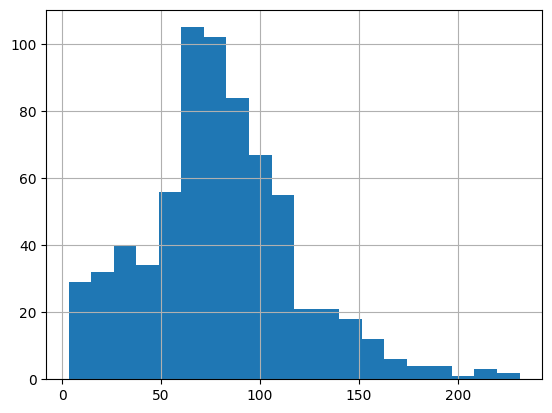

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~55528.52


<Axes: >

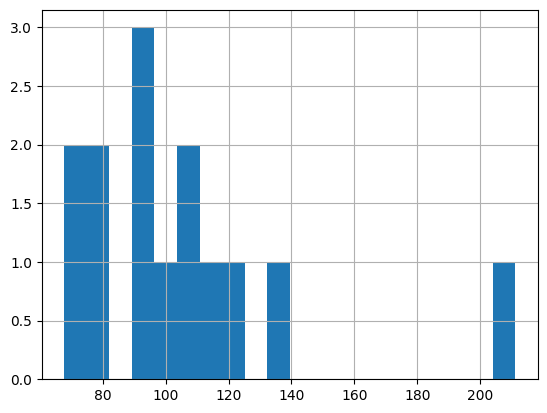

In [21]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Vocab']['age'].hist(bins=20)

# Completely Random Shuffle

In [22]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [23]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [24]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [25]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [26]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [ ]:
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

choices = ['floor', 'mod']
option = random.choice(choices)
if option == 'floor':
    n=5
    existing_cards['n_fold'] = existing_cards['count'] // n
    print("floor dividing for n-fold")
elif option == 'mod':
    n=3
    existing_cards['n_fold'] = existing_cards['count'] % n
    print("modulo for n-fold")
else: raise NotImplementedError


if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 696
Total card age: 55528.52


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
467,Terraform,Remember that variables can't reference each o...,c938ff1e867840093c794fe980ec1385,4.805676,4.765991,-4.805676,9.531983,0.576582,2,0,0,-4.805676
231,Terraform,You can't nest subnets in Azure! It's embarras...,fcd464f48b593ead6cbb10c437fa16d1,4.726306,4.765991,-4.805676,9.531983,0.576582,2,1,0,-4.726306
74,Azure Compute Gallery,Azure DevOps Pipelines for Image Deployment – ...,7f9dc58f909efc213b64a0697735712c,162.652778,96.097239,-162.652778,672.680674,0.099981,7,0,0,-162.652778
315,Azure Compute Gallery,Replication Time Constraints – Image replicati...,f5615ce9f50e2f668a32d12784e21991,118.267704,96.097239,-162.652778,672.680674,0.099981,7,1,0,-118.267704
548,Azure Compute Gallery,Image Retention Policy – A strategy for keepin...,70c2d698cafb110aac81fc77dbba5e31,105.914979,96.097239,-162.652778,672.680674,0.099981,7,2,0,-105.914979
75,Azure Compute Gallery,Azure Marketplace Image as a Base – Using a pr...,0d150bb03591ea0166f17b89e7412ee1,91.111483,96.097239,-162.652778,672.680674,0.099981,7,3,0,-91.111483
316,Azure Compute Gallery,Shared Image Gallery Reader Role – An RBAC rol...,5c68211134057fa344eb09d9183da05a,71.824649,96.097239,-162.652778,672.680674,0.099981,7,4,0,-71.824649
53,pfSense,"To check for updates to pfSense software, navi...",438fd54e363098f3194d6e2a852d90ee,187.719899,99.990801,-187.719899,1199.889612,0.360361,12,0,0,-187.719899
294,pfSense,Netgate offers an automatic configuration back...,c4c4fc2311055ca400c5798ddfdf4b7a,146.854293,99.990801,-187.719899,1199.889612,0.360361,12,1,0,-146.854293
528,pfSense,OPT\nOPT or Optional interfaces refer to any a...,4abde57f8cc39259acb1aaa915667281,114.524152,99.990801,-187.719899,1199.889612,0.360361,12,2,0,-114.524152



## Random

In [28]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [29]:
existing_cards.head(10)['age'].sum()

np.float64(1008.4019203156342)

In [30]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
83,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,231.133752,91.390542,-231.133752,4569.527125,0.547677,50,0,0,-231.133752
4,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,226.229476,104.826963,-226.229476,4088.251543,0.591684,39,0,0,-226.229476
246,JavaScript Concepts,Many operators coerce the operands into number...,c7910dc971abc5da390f0193c2ffbdc8,219.190739,104.826963,-226.229476,4088.251543,0.591684,39,1,0,-219.190739
232,Vocab,"How to Sell a Haunted House, Hendrix\nStollen ...",2f0f1d406aece7f1fd77835411449718,211.058548,105.480900,-211.058548,1476.732601,0.058414,14,0,0,-211.058548
323,Microsoft Purview,Run the policy in simulation mode with notific...,3a95ac540d1e377383ba60aeb1da4f08,210.587508,91.390542,-231.133752,4569.527125,0.547677,50,1,0,-210.587508
481,JavaScript Concepts,Logical AND (&&) and OR (||) Statements\nif (c...,8541c9ae716e3f5474869ab92784fcc8,200.219156,104.826963,-226.229476,4088.251543,0.591684,39,2,0,-200.219156
239,PnP PowerShell,OAuth 2.0 Client Credentials Flow\nAn authenti...,c90c2d49a1ca2f62bae14c4a35f4e965,196.069330,96.789496,-196.069330,1645.421426,0.973808,17,0,0,-196.069330
30,"The Starless Crown, Rollins",Sibilant (SIB-ih-luhnt)\nadjective\nProducing ...,09e242a89b2c3c7bb3b51aa8b046ada1,192.613886,101.196432,-192.613886,2732.303652,0.989592,27,0,0,-192.613886
555,Microsoft Purview,DLP reports a vast amount of information to Mi...,21125699205a471834408e12af92973d,192.228228,91.390542,-231.133752,4569.527125,0.547677,50,2,0,-192.228228
53,pfSense,"To check for updates to pfSense software, navi...",438fd54e363098f3194d6e2a852d90ee,187.719899,99.990801,-187.719899,1199.889612,0.360361,12,0,0,-187.719899


In [31]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 79.782'